# observe data

In [1]:
# pip install --upgrade torchvision

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import random
from PIL import Image

import torchvision
torchvision.disable_beta_transforms_warning()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision.models as models    # VGG16, ResNet50
# from torchsummary import summary       # summary for models
from torch.utils.tensorboard import SummaryWriter

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import pydicom
import matplotlib.pyplot as plt
import plotly.express as px


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [28]:
class Config:

    root = '/kaggle/input/government'
    batch_size = 16
    valid_prob = 0.2
    lr = 5e-5
    epochs = 50
    weight_decay = 1e-3
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    seed = 42


In [4]:
data_gov = pd.read_excel(Config.root + '/class.xlsx', sheet_name = '政府機關')
data_com = pd.read_excel(Config.root + '/class.xlsx', sheet_name = '公司')

data = pd.concat((data_gov, data_com))
idx = data[data['名稱']=='?'].index
data = data.drop(idx)
# font_idx = data[data['字體'].isin(['圓體', '印刷體'])].index
# data = data.drop(font_idx)

data['font_label'], label_mapping = pd.factorize(data['字體'])

img_paths = Config.root + '/'+ data.loc[:, '類型']+ '/'+ data.loc[:, '名稱'] +'/'+ data.loc[:, '影像路徑']
data['img_path'] = img_paths

# Labels
label_list = data.iloc[:, -2]

data

,類型,名稱,印章類型,nothing,字母,影像路徑,字體,備註,font_label,img_path
0,政府單位,台北地檢,1,關防/AG002.png,A,AG002.png,宋體,NaN,0,/kaggle/input/government/政府單位/台北地檢/AG002.png
1,政府單位,台北地檢,1,關防/AG003.png,NaN,AG003.png,宋體,NaN,0,/kaggle/input/government/政府單位/台北地檢/AG003.png
2,政府單位,台中地檢,1,關防/AG001.png,NaN,AG001.png,隸書,NaN,1,/kaggle/input/government/政府單位/台中地檢/AG001.png
3,政府單位,士林地檢,1,關防/AG004.png,NaN,AG004.png,方篆,NaN,2,/kaggle/input/government/政府單位/士林地檢/AG004.png
4,政府單位,台北地院,2,關防/AG006.png,NaN,AG006.png,方篆,NaN,2,/kaggle/input/government/政府單位/台北地院/AG006.png
...,...,...,...,...,...,...,...,...,...,...
358,公司,股達寶投資,1,NaN,NaN,PS352.png,方篆,印篆,2,/kaggle/input/government/公司/股達寶投資/PS352.png
359,公司,股達寶投資,1,NaN,NaN,PS353.png,方篆,印篆,2,/kaggle/input/government/公司/股達寶投資/PS353.png
361,公司,量石資本,1,NaN,NaN,PS354-2.png,方篆,印篆,2,/kaggle/input/government/公司/量石資本/PS354-2.png
364,公司,紐約梅隆,1,NaN,NaN,QS357.png,楷書,楷書,3,/kaggle/input/government/公司/紐約梅隆/QS357.png


In [5]:
data.groupby(['font_label', '字體']).size().reset_index(name='count')

,font_label,字體,count
0,0,宋體,30
1,1,隸書,74
2,2,方篆,299
3,3,楷書,63
4,4,小篆,8
5,5,行書,3
6,6,圓體,1
7,7,印刷體,1


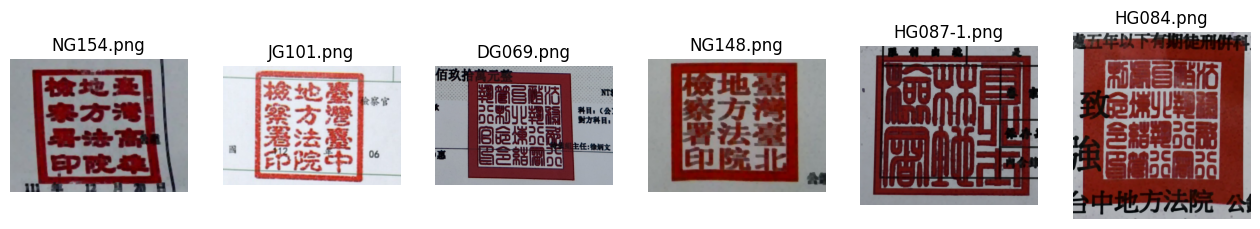

In [6]:
plt.figure(figsize=(16, 4))

dep_name = os.listdir(Config.root + '/政府單位')
image_name = []
for i in dep_name:
    image_name.append(os.listdir(Config.root + '/政府單位/' + i)[0])
    
for i in range(len(image_name)):
    image_path = Config.root + '/政府單位/' + dep_name[i] + '/' + image_name[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=cv2.erode(image,None,iterations=5)
    image=cv2.dilate(image,None,iterations=2)
    plt.subplot(1, 6, i + 1)
    plt.imshow(image)
    plt.title(image_name[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
# ['高雄地檢', '台中地檢', '台北地院', '台北地檢', '士林地檢', '台中地院']

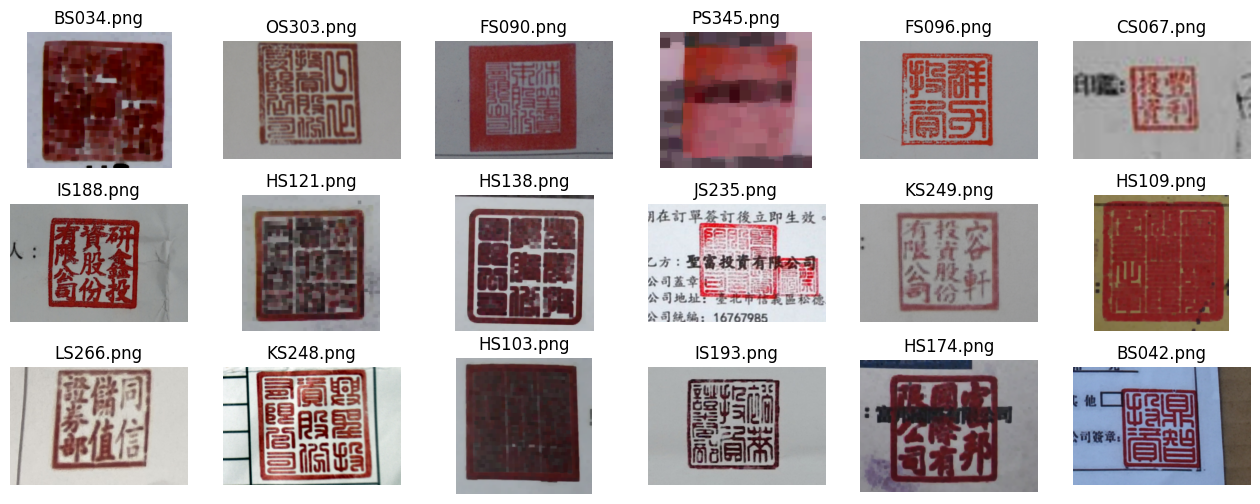

In [7]:
plt.figure(figsize=(16, 6))

dep_name = os.listdir(Config.root + '/公司')[:18]
image_name = []
for i in dep_name:
    image_name.append(os.listdir(Config.root + '/公司/' + i)[0])
    
for i in range(len(image_name)):
    image_path = Config.root + '/公司/' + dep_name[i] + '/' + image_name[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=cv2.erode(image,None,iterations=5)
    image=cv2.dilate(image,None,iterations=2)
    plt.subplot(3, 6, i + 1)
    plt.imshow(image)
    plt.title(image_name[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

# Define Functions

In [8]:
def seed_everything(seed):

    # set Python random seed
    random.seed(seed)

    # set Numpy random seed
    np.random.seed(seed)

    # set Pytorch random seed for gpu and cpu
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # set Pytorch deterministic operation for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = 'macro')

    return acc, f1

In [10]:
def train_one_epochs(model, train_loader, device, optimizer, scheduler, criterion):

    model.train()
    train_loss = .0
    predictions, ground_truths = [], []

    for images, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images)
        
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, train_acc*100, train_f1*100
    

In [11]:
def validation(model, valid_loader, device, criterion):
    
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    with torch.no_grad():

        for images, labels in valid_loader:
            images = images.to(device = device, dtype = torch.float)
            labels = labels.to(device = device, dtype = torch.long)

            logits = model(images)
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim = 1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)
        
        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)

    return valid_loss, valid_acc*100, valid_f1*100


# Dataset

In [12]:
!pip install rembg
from rembg import remove

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 46.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.4 MB/s eta 0:00:00


In [13]:
class FontDataset(Dataset):
    def __init__(self,df,transforms = None):
        self.image_paths = np.array(df['img_path'])
        self.labels = np.array(df['font_label'])
        self.images=[]
        self.transforms = transforms
        
        for path in self.image_paths:
            image = Image.open(path).convert('RGB')
            image = remove(image)
            image = image.convert('RGB')
            if self.transforms:
                image = self.transforms(image)
                
            self.images.append(image)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        label = self.labels[idx]
        image = self.images[idx]
        
        return image, label
    
from torchvision.transforms import functional as F
        
class My_normalization(object):
    def __call__(self, image):
        image_tensor = F.to_tensor(image)
        image_tensor = F.convert_image_dtype(image_tensor, dtype=torch.float)
        new_image = (image_tensor - image_tensor.mean()) / (image_tensor.max() - image_tensor.min())
        return new_image
    
My_transforms = v2.Compose([
    v2.Resize((256, 256)),
    My_normalization()
])

In [14]:
test_data = data.sample(frac=0.1, random_state=1)
test_data_indices = test_data.index
train_data = data.drop(test_data_indices).reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(train_data.shape, test_data.shape)

(403, 10) (48, 10)


In [15]:
dataset = FontDataset(train_data,transforms = My_transforms)

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 145GB/s]


In [16]:
m = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
print(m)

input = torch.randn([1, 3, 50, 50])
print(input.shape)

output = m(input)
print(output.shape)

for param in m.parameters():
    print(param.shape)

del m, input, output

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 3, 50, 50])
torch.Size([1, 64, 50, 50])
torch.Size([64, 3, 3, 3])
torch.Size([64])


Image Shape: torch.Size([16, 3, 256, 256]), Label Shape: torch.Size([])


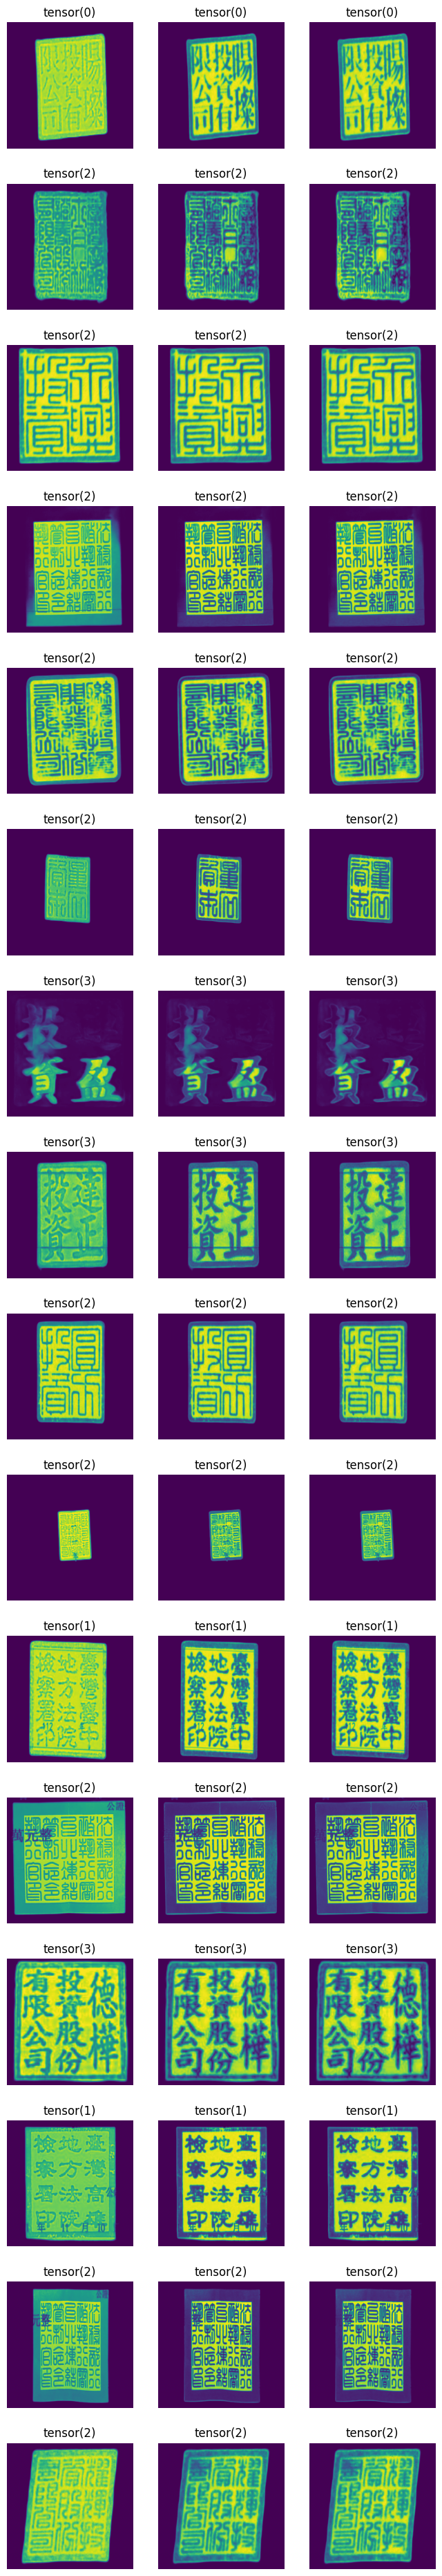

In [17]:
plt.figure(figsize = (8, 48))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=Config.batch_size, shuffle=True)

images, labels = next(iter(train_loader))

for i, (image, label) in enumerate(zip(images, labels)):
    for j in range(3):  # RGB    
        plt.subplot(16, 3, i*3 + j+1)
        plt.imshow(image[j])
        plt.title(label)
        plt.axis('off')

print(f'Image Shape: {images.shape}, Label Shape: {label.shape}')

# ResNet50

In [18]:
class RESplus(nn.Module):

    # 默認輸出為分類到每一類的機率
    def __init__(self, num_class, input_size = (3, 50, 50), out_prob = True, features_grad = False):

        super().__init__()

        # 決定是否將輸出轉為機率
        self.out_prob = out_prob

        # 從 VGG16 提取特徵層
        res50 = models.resnet50(weights='IMAGENET1K_V1', progress = True)
        res50.fc = nn.Identity()
        res50.avgpool = nn.AdaptiveAvgPool2d(1)

        # 固定或不固定特徵層的參數值
        for param in res50.fc.parameters():
            param.requires_grad = features_grad
        self.backend = res50

        # 增加分類層
        self.classifier = nn.Sequential(
            nn.Linear(2048, num_class)
        )
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        output = self.backend(x)
        output = output.view(output.size(0), -1)
        outputs = self.classifier(output)
        return outputs



In [19]:
def main(dataset, model_class):

    seed_everything(Config.seed)

    # train, test dataframe
#     train_df = pd.read_csv(Config.root + '/train-csv/train.csv')
#     test_df = pd.read_csv(Config.root + '/test-csv/test.csv')

    # Dataset
    print('Initialize dataset')
    #dataset = FontDataset(image_paths=train_data['img_path'], labels=train_data['font_label'], transforms = My_transforms)
#     print('Initialize test dataset')
#     test_dataset = ParkinsonsDataset(image_paths=test_data['img_path'], transforms=My_transforms)

    # spilting training set and validation set
    n = len(dataset)
    valid_size = int(n * Config.valid_prob)
    train_ids, valid_ids = train_test_split(
        np.linspace(0, n-1, n).astype('int'),
        test_size = valid_size,
        random_state=Config.seed
    )
    print(f'Number of samples in train dataset: {len(train_ids)}')
    print(f'Number of samples in validation dataset: {len(valid_ids)}')

    # DataLoader
    train_dataset = torch.utils.data.Subset(dataset, train_ids)
    valid_dataset = torch.utils.data.Subset(dataset, valid_ids)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)
#     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)

    # setting
    print('Initializing model...')
    num_class = len(set(label_list))
    model = model_class(num_class=num_class, features_grad=True)
    device = Config.device
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = Config.lr, weight_decay=Config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        epochs = Config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr=Config.lr,
        anneal_strategy='cos'
    )

    # recording
    best_val_loss = float('inf')
    history = {
        'train' : {'loss' : [], 'acc' : [], 'f1' : []},
        'valid' : {'loss' : [], 'acc' : [], 'f1' : []}
    }

    for epoch in range(Config.epochs):
        
        #if torch.cuda.is_available():
            #print(f"Current device: {torch.cuda.get_device_name(device)}")
            #print(f"Memory Allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")
            #print(f"Memory Cached: {torch.cuda.memory_reserved(device) / (1024 ** 2):.2f} MB")
        #else:
            #print("No GPU available, using CPU")
            
            
        train_loss, train_acc, train_f1 = train_one_epochs(model, train_loader, device, optimizer, scheduler,  criterion)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, device, criterion)

        history['train']['loss'].append(train_loss)
        history['train']['acc'].append(train_acc)
        history['train']['f1'].append(train_f1)
        history['valid']['loss'].append(valid_loss)
        history['valid']['acc'].append(valid_acc)
        history['valid']['f1'].append(valid_f1)

        print(f'Epoch[{epoch + 1}/ {Config.epochs}], Train Loss: {train_loss: .4f}, Train Accuracy: {train_acc: .2f}%, Train F1: {train_f1: .2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'schedular': scheduler.state_dict(),
                'epoch': epoch,
                'args': Config
            }
            best_val_loss = valid_loss
            torch.save(save_file, f'checkpoint_{model_class.__name__}.pth')
            
        #torch.serialization.add_safe_globals([Config])
    best_ckpt_vgg = torch.load(f'checkpoint_{model_class.__name__}.pth', map_location=device)
    model.load_state_dict(best_ckpt_vgg['model'])

    plt.figure(figsize = (8, 6))
    plt.plot(range(Config.epochs), history['train']['loss'])
    plt.plot(range(Config.epochs), history['valid']['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize = (8, 6))
    plt.plot(range(Config.epochs), history['train']['acc'])
    plt.plot(range(Config.epochs), history['valid']['acc'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize = (8, 6))
    plt.plot(range(Config.epochs), history['train']['f1'])
    plt.plot(range(Config.epochs), history['valid']['f1'])
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score')
    plt.show()

Initialize dataset
Number of samples in train dataset: 323
Number of samples in validation dataset: 80
Initializing model...
Epoch[1/ 50], Train Loss:  1.9866, Train Accuracy:  12.69%, Train F1:  6.32% | Valid Loss: 1.9739, Valid Accuracy: 13.75%, Valid F1: 8.09% | LR: 0.000003
Epoch[2/ 50], Train Loss:  1.8395, Train Accuracy:  31.89%, Train F1:  18.83% | Valid Loss: 1.7591, Valid Accuracy: 48.75%, Valid F1: 27.73% | LR: 0.000004
Epoch[3/ 50], Train Loss:  1.6334, Train Accuracy:  64.09%, Train F1:  37.78% | Valid Loss: 1.5011, Valid Accuracy: 78.75%, Valid F1: 46.87% | LR: 0.000007
Epoch[4/ 50], Train Loss:  1.3117, Train Accuracy:  85.76%, Train F1:  49.41% | Valid Loss: 1.1358, Valid Accuracy: 90.00%, Valid F1: 67.06% | LR: 0.000010
Epoch[5/ 50], Train Loss:  0.9239, Train Accuracy:  90.40%, Train F1:  53.58% | Valid Loss: 0.7071, Valid Accuracy: 91.25%, Valid F1: 67.93% | LR: 0.000014
Epoch[6/ 50], Train Loss:  0.5396, Train Accuracy:  92.88%, Train F1:  56.05% | Valid Loss: 0.427

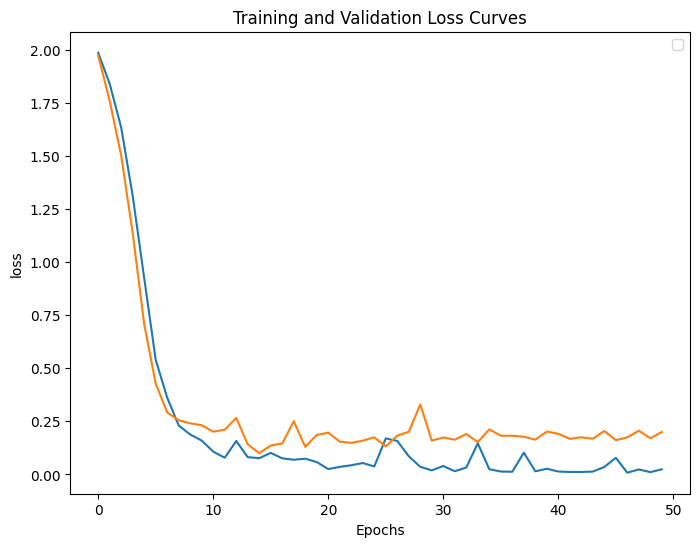

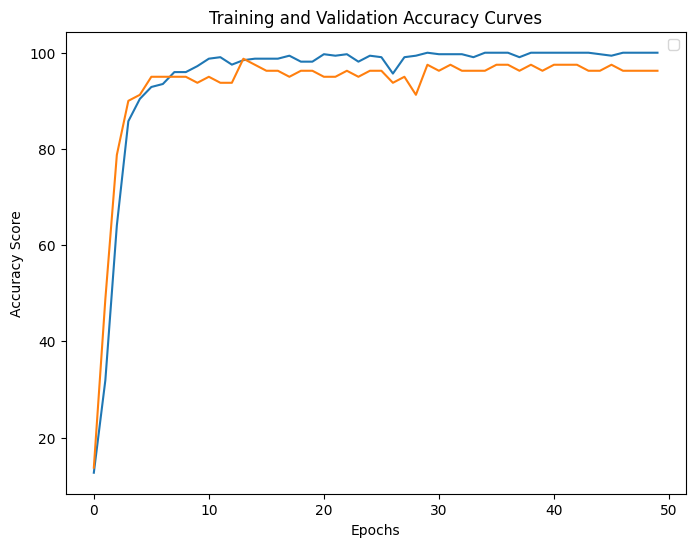

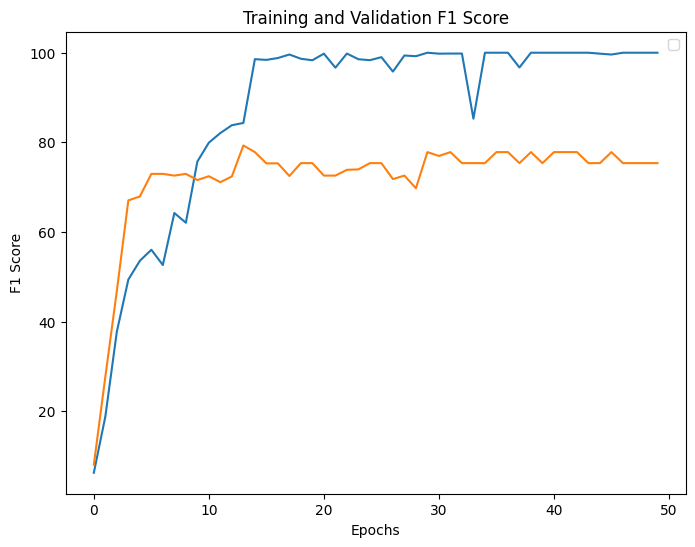

In [29]:
if __name__ == '__main__':
    main(dataset, RESplus)

In [21]:
model = RESplus(num_class=len(set(label_list)), features_grad=True)

best_ckpt_vgg = torch.load("checkpoint_RESplus.pth", map_location = Config.device)
model.load_state_dict(best_ckpt_vgg['model'])

<All keys matched successfully>

In [22]:
class FontDataset_test(Dataset):
    def __init__(self,df,transforms = None):
        self.image_paths = np.array(df['img_path'])
        self.images=[]
        self.transforms = transforms
        
        for path in self.image_paths:
            image = Image.open(path).convert('RGB')
            image = remove(image)
            image = image.convert('RGB')
            if self.transforms:
                image = self.transforms(image)
                
            self.images.append(image)
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        
        return image

In [23]:
test_dataset = FontDataset_test(test_data, transforms=My_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = Config.batch_size, shuffle = False)

def test_pred(model, test_loader, device):
    model.eval()
    model.to(device)
    
    predictions, probabilities = [], []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device=device, dtype=torch.float)

            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            predictions.append(preds)
            probabilities.append(probs)
        
    predictions = torch.cat(predictions)
    probabilities = torch.cat(probabilities)
    
    return probabilities, predictions

In [24]:
pred_label = test_pred(model, test_loader, Config.device)

count = 0
for i in range(len(test_data)):
    if test_data['font_label'][i] == pred_label[1][i]:
        count += 1

print(f"Accuracy of ResNet50: {count / len(test_data) * 100}%")

Accuracy of ResNet50: 100.0%
